In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Pt. 1 - Creating entities - table and agent

In [2]:
class PacardoTable:
    def __init__(self, rows, cols):
        self.rows = rows
        self.cols = cols
        self.table = np.zeros((4, cols*rows))
        self.actions =  {
            "UP": self.table[0, :],
            "LEFT": self.table[1, :],
            "RIGHT": self.table[2, :],
            "DOWN": self.table[3, :]
        }
        
    def update(self, state, action, reward, next_state_value, gamma_discount = 0.9, alpha = 0.5):
        """
        Обновляет таблицу, используя значения наград и следующего состояния
        Q(S, A) <- Q(S, A) + [alpha * (reward + (gamma * maxValue(Q(S', A'))) -  Q(S, A) ],
        Q(S, A) <- Q(S, A) + [alpha * (reward + (gamma * Q(S', A')) -  Q(S, A) ]
        """
        caef = alpha * (reward + (gamma_discount * next_state_value) - self.table[action, state])
        self.table[action, state] += caef
        return self.table

In [3]:
class PacardoCliffAgent:
    
    def __init__(self, start_position, rows=4, cols=12):
        self.position = start_position
        self.env = np.zeros((rows, cols))
        self.rows = rows
        self.cols = cols
        self.track_env()
        
    def epsilon_greedy_policy(self, state, pacardoTable, epsilon = 0.1):
        decide_explore_exploit  = np.random.random()
        if(decide_explore_exploit < epsilon):
            action = np.random.choice(4)
        else:
            action = np.argmax(pacardoTable.table[:, state])
        return action
    
    def move(self, action):
        
        (posX , posY) = self.position
        if ((action == 0) and posX > 0):
            posX = posX - 1
        if((action == 1) and (posY > 0)):
            posY = posY - 1
        if((action == 2) and (posY < 11)):
            posY = posY + 1
        if((action) == 3 and (posX < 3)):
            posX = posX + 1
        self.position = (posX, posY)
        self.track_env()
        return self.position
    
    def reward(self, state):
        game_end = False
        reward = -1
        if(state == 47):
            game_end = True
            reward = -1
        if(state >= 37 and state <= 46):
            game_end = True
            reward = -100

        return reward, game_end
    
    def track_env(self):
        (posY, posX) = self.position
        self.env[posY][posX] = 1

# Pt 2. Creating solvers - SARSA and Q-Learning

In [4]:
class IPacardoSolver():
    def fit():
        pass
    def get_state():
        pass
        

In [5]:
class SarsaLearningPacardoSolver(IPacardoSolver):
    def __init__(
        self, 
        num_episodes = 500,
        gamma_discount = 0.9,
        alpha = 0.5,
        epsilon = 0.1
    ):
        self.num_episodes = num_episodes
        self.gamma_discount = gamma_discount
        self.alpha = alpha
        self.epsilon = epsilon
        
    def fit(self):
        reward_cache = list()
        step_cache = list()
        table = PacardoTable(4, 12)
        for episode in range(0, self.num_episodes):
            agent = PacardoCliffAgent((3, 0))
            game_end = False
            reward_cum = 0
            step_cum = 0
            while(game_end == False):
                step_cum += 1
                state = self.get_state(agent, table)
                action = agent.epsilon_greedy_policy(state, table)
                agent.move(action)
                next_state = self.get_state(agent, table)
                next_state_value = table.table[action][next_state]
                reward, game_end = agent.reward(next_state)
                reward_cum += reward 
                table.update(state, action, reward, next_state_value, self.gamma_discount, self.alpha)
                state = next_state
            reward_cache.append(reward_cum)
            if(episode > 498):
                print("Agent trained with SARSA-learning after 500 iterations")
                print(agent.env) 
            step_cache.append(step_cum)
        return table, reward_cache, step_cache
    
    def get_state(self, pacardoAgent, pacardoTable):
        (posX , posY) = pacardoAgent.position
        return pacardoAgent.cols * posX + posY

In [6]:
class QLearningPacardoSolver(IPacardoSolver):
    def __init__(
        self, 
        num_episodes = 500,
        gamma_discount = 0.9,
        alpha = 0.5,
        epsilon = 0.1
    ):
        self.num_episodes = num_episodes
        self.gamma_discount = gamma_discount
        self.alpha = alpha
        self.epsilon = epsilon
    
    def fit(self):
        reward_cache = list()
        step_cache = list()
        table = PacardoTable(4, 12)
        for episode in range(0, self.num_episodes):
            agent = PacardoCliffAgent((3, 0))
            game_end = False
            reward_cum = 0
            step_cum = 0
            while(game_end == False):
                step_cum += 1
                state, _ = self.get_state(agent, table)
                action = agent.epsilon_greedy_policy(state, table)
                agent.move(action)
                next_state, max_next_state_value = self.get_state(agent, table)
                reward, game_end = agent.reward(next_state)
                reward_cum += reward 
                table.update(state, action, reward, max_next_state_value, self.gamma_discount, self.alpha)
                state = next_state
            reward_cache.append(reward_cum)
            if(episode > 498):
                print("Agent trained with Q-learning after 500 iterations")
                print(agent.env) 
            step_cache.append(step_cum)
        return table, reward_cache, step_cache

    def get_state(self, pacardoAgent, pacardoTable):
        (posX , posY) = pacardoAgent.position

        state = pacardoAgent.cols * posX + posY

        state_action = pacardoTable.table[:, int(state)]
        maximum_state_value = np.amax(state_action)
        return state, maximum_state_value

# pt. 3 Plotting Functions

In [7]:
def retrieve_environment(q_table, action):
    env = q_table[action, :].reshape((4, 12))
    print(env)
  

In [8]:
def plot_cumreward_normalized(reward_cache_qlearning, reward_cache_SARSA):
    cum_rewards_q = []
    rewards_mean = np.array(reward_cache_qlearning).mean()
    rewards_std = np.array(reward_cache_qlearning).std()
    count = 0 # used to determine the batches
    cur_reward = 0 # accumulate reward for the batch
    for cache in reward_cache_qlearning:
        count = count + 1
        cur_reward += cache
        if(count == 10):
            # normalize the sample
            normalized_reward = (cur_reward - rewards_mean)/rewards_std
            cum_rewards_q.append(normalized_reward)
            cur_reward = 0
            count = 0
            
    cum_rewards_SARSA = []
    rewards_mean = np.array(reward_cache_SARSA).mean()
    rewards_std = np.array(reward_cache_SARSA).std()
    count = 0 # used to determine the batches
    cur_reward = 0 # accumulate reward for the batch
    for cache in reward_cache_SARSA:
        count = count + 1
        cur_reward += cache
        if(count == 10):
            # normalize the sample
            normalized_reward = (cur_reward - rewards_mean)/rewards_std
            cum_rewards_SARSA.append(normalized_reward)
            cur_reward = 0
            count = 0      
    # prepare the graph    
    plt.plot(cum_rewards_q, label = "q_learning")
    plt.plot(cum_rewards_SARSA, label = "SARSA")
    plt.ylabel('Cumulative Rewards')
    plt.xlabel('Batches of Episodes (sample size 10) ')
    plt.title("Q-Learning/SARSA Convergence of Cumulative Reward")
    plt.legend(loc='lower right', ncol=2, mode="expand", borderaxespad=0.)
    plt.show()
    

In [9]:
def plot_number_steps(step_cache_qlearning, step_cache_SARSA): 
    cum_step_q = []
    steps_mean = np.array(step_cache_qlearning).mean()
    steps_std = np.array(step_cache_qlearning).std()
    count = 0
    cur_step = 0
    for cache in step_cache_qlearning:
        count = count + 1
        cur_step += cache
        if(count == 10):
            normalized_step = (cur_step - steps_mean)/steps_std
            cum_step_q.append(normalized_step)
            cur_step = 0
            count = 0
            
    cum_step_SARSA = []
    steps_mean = np.array(step_cache_SARSA).mean()
    steps_std = np.array(step_cache_SARSA).std()
    count = 0
    cur_step = 0
    for cache in step_cache_SARSA:
        count = count + 1
        cur_step += cache
        if(count == 10):
            normalized_step = (cur_step - steps_mean)/steps_std
            cum_step_SARSA.append(normalized_step)
            cur_step = 0
            count = 0         
    plt.plot(cum_step_q, label = "q_learning")
    plt.plot(cum_step_SARSA, label = "SARSA")
    plt.ylabel('Number of iterations')
    plt.xlabel('Batches of Episodes (sample size 10) ')
    plt.title("Q-Learning/SARSA Iteration number untill game ends")
    plt.legend(loc='lower right', ncol=2, mode="expand", borderaxespad=0.)
    plt.show()
    

    

In [10]:
def plot_qlearning_smooth(reward_cache):
    mean_rev = (np.array(reward_cache[0:11]).sum())/10
    cum_rewards = [mean_rev] * 10
    idx = 0
    for cache in reward_cache:
        cum_rewards[idx] = cache
        idx += 1
        smooth_reward = (np.array(cum_rewards).mean())
        cum_rewards.append(smooth_reward)
        if(idx == 10):
            idx = 0
        
    plt.plot(cum_rewards)
    plt.ylabel('Cumulative Rewards')
    plt.xlabel('Batches of Episodes (sample size 10) ')
    plt.title("Q-Learning  Convergence of Cumulative Reward")
    plt.legend(loc='lower left', ncol=2, mode="expand", borderaxespad=0.)
    plt.show()

In [11]:
def generate_heatmap(q_table):
    import seaborn as sns; sns.set()
    data = np.mean(q_table, axis = 0)
    print(data)
    data = data.reshape((4, 12))
    ax = sns.heatmap(np.array(data))
    return ax

# Pt 4.  - Models training

In [12]:
q_table_SARSA, reward_cache_SARSA, step_cache_SARSA = SarsaLearningPacardoSolver().fit()
q_table_qlearning, reward_cache_qlearning, step_cache_qlearning = QLearningPacardoSolver().fit()
    

Agent trained with SARSA-learning after 500 iterations
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 1.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]
Agent trained with Q-learning after 500 iterations
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]


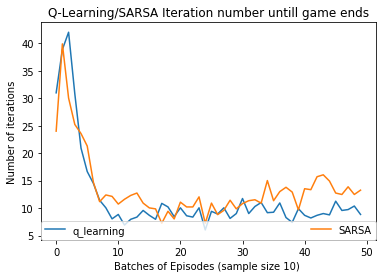

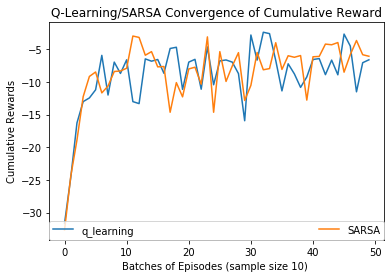

In [13]:
plot_number_steps(step_cache_qlearning, step_cache_SARSA)
plot_cumreward_normalized(reward_cache_qlearning,reward_cache_SARSA)

Visualize environment Q-learning


/Users/astronaut/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


[ -7.34723206  -7.17031144  -6.91218898  -6.64095367  -6.34855637
  -5.94961336  -5.57770196  -5.10797852  -4.70909987  -4.30423206
  -3.63221434  -2.85373812  -7.4378276   -7.25622699  -6.95297672
  -6.70391696  -6.21597204  -5.79755645  -5.30383328  -4.8826156
  -4.40735725  -3.91077482  -3.07883496  -2.5262664   -7.49281661
 -30.43790448 -30.20408287 -29.91118578 -29.66270093 -29.34155149
 -29.00848255 -28.62610607 -28.19886624 -27.71654845 -26.78182855
  -2.07517538 -30.71784822   0.           0.           0.
   0.           0.           0.           0.           0.
   0.           0.           0.        ]
AxesSubplot(0.125,0.125;0.62x0.755)


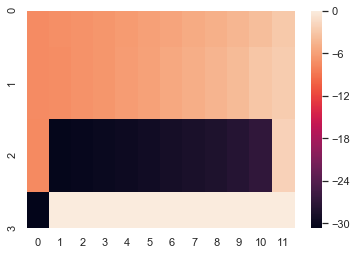

In [14]:
print("Visualize environment Q-learning")
ax_q = generate_heatmap(q_table_qlearning.table)
print(ax_q) 

Visualize SARSA
[ -8.02513824 -14.43103401 -20.73667284 -18.05744346 -14.62735437
 -16.64379794 -10.93393644 -16.78181338 -23.76887507 -22.09431582
 -20.21927411  -3.85035926  -8.20437685 -25.90195954 -26.78240583
 -23.49302544 -19.83200821 -27.6213813  -24.60681793 -18.43061864
 -26.77783069 -24.5574625  -22.29981424  -4.26315402  -8.5596702
 -31.28933541 -31.16691923 -30.88268233 -30.84567863 -30.57704447
 -30.27525297 -30.17452359 -29.53220902 -29.23534084 -27.73855469
  -4.26869597 -31.54552876   0.           0.           0.
   0.           0.           0.           0.           0.
   0.           0.           0.        ]
AxesSubplot(0.125,0.125;0.62x0.755)


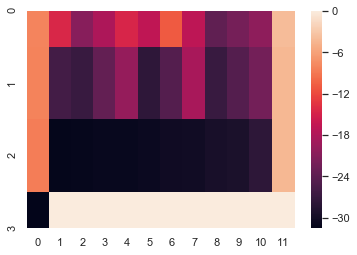

In [15]:
print("Visualize SARSA")
ax_SARSA = generate_heatmap(q_table_SARSA.table)
print(ax_SARSA)